In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
import numpy as np

## Price Data

In [3]:
files = glob.glob("../data/prices/*")

In [82]:
prices = [json.loads(line[:-2]) for line in open(files[0], 'r')]

In [83]:
df = pd.DataFrame(prices)
df['ts'] = pd.to_datetime(df['ts'], unit = 'ms')
df = df.set_index('ts')

In [84]:
df.head()

,mid_price,spread,best_bid,best_ask,best_bid_size,best_ask_size,vamp,order_imbalance,buffer_ready,volatility
ts,,,,,,,,,,
2024-08-13 02:22:28.169561088,266338.5000,369.0000,266154.0000,266523.0000,0.0065,0.2386,266391.2128635185844682370237,0.3137766188613646240764884833,False,None
2024-08-13 02:22:29.261402112,266338.5000,357.0000,266160.0000,266517.0000,0.0058,0.2226,266461.9286375395869574914135,0.2231404958677685950413223140,False,None
2024-08-13 02:22:30.320442880,266331.0000,366.0000,266148.0000,266514.0000,0.0058,0.0163,266375.8760456153159871024966,0.3014357401728463897407304154,False,None
2024-08-13 02:22:31.374043904,266332.0000,360.0000,266152.0000,266512.0000,0.0198,0.1678,266477.0099022171892377091150,0.3415644820295983086680761099,False,None
2024-08-13 02:22:32.379913984,266330.5000,353.0000,266154.0000,266507.0000,0.0122,0.1475,266406.1585109779150390800145,0.2792891619131197893813075910,False,None


In [85]:
df['volatility'] = np.where(df['volatility']=="None", np.nan, df['volatility'])

In [86]:
for col in ["mid_price","spread","best_bid","best_ask","best_bid_size","best_ask_size","vamp","order_imbalance","volatility"]:
    df[col] = pd.to_numeric(df[col])

Text(0.5, 1.0, 'Volatility')

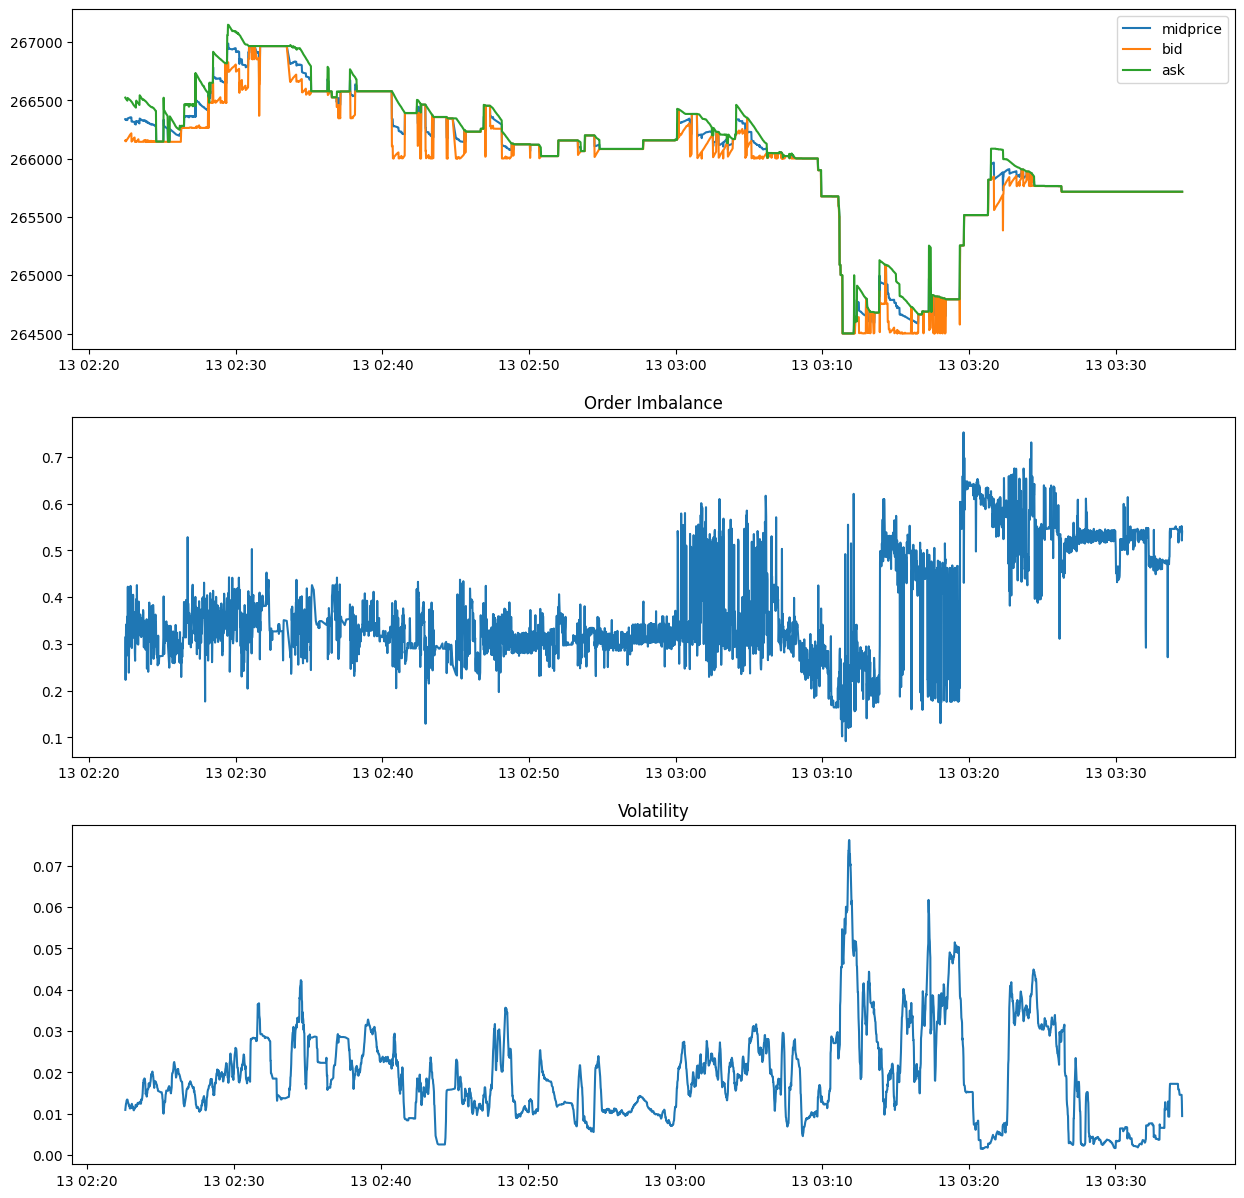

In [89]:
fig, (ax1,ax2, ax3) = plt.subplots(3,1, figsize = (15,15))
ax1.plot(df.mid_price,label="midprice")
ax1.plot(df.best_bid, label = "bid")
ax1.plot(df.best_ask, label ="ask")
#ax1.plot(df.vamp, label = "vamp")
ax1.legend()
ax2.plot(df.order_imbalance)
ax2.set_title("Order Imbalance")
ax3.plot(df.volatility)
ax3.set_title("Volatility")

## Microstructure of Market Orders

In [90]:
glob.glob("../data/trades/*")

['../data/trades/trades_XBTMYR.json']

In [92]:
trades = pd.DataFrame([json.loads(line[:-2]) for line in open(glob.glob("../data/trades/*")[0], 'r')])

In [93]:
trades.head()

,ts,price,amount,bidask
0,1723515782092,266171.0,0.003990,ask
1,1723515862328,266436.0,0.000309,bid
2,1723515905806,266146.0,0.000444,ask
3,1723515944599,266313.0,0.000375,bid
4,1723515970572,266247.0,0.005782,bid


In [99]:
trades.amount.describe()

count    162.000000
mean       0.007120
std        0.009782
min        0.000025
25%        0.000687
50%        0.002732
75%        0.011726
max        0.055601
Name: amount, dtype: float64

In [102]:
for col in ['price','amount']:
    trades[col] = pd.to_numeric(trades[col])

### Arrival time

### CDF

$PnL * P[\text{Filled in the next trade}]$

$PnL_{buy} = Distance_{buy} - fee$

$PnL_{sell} = Distance_{sell} - fee$

In [103]:
buy_trades = trades.loc[trades['bidask']=="bid"]
sell_trades = trades.loc[trades['bidask']=="ask"]

In [111]:
buy_cdf = []
sell_cdf = []

In [112]:
range = np.arange(0.00001, 0.06, 0.00001)
for size in range:
    filtered_buy_trades = buy_trades[buy_trades['amount'] >= size]
    filtered_sell_trades = sell_trades[sell_trades['amount'] >= size]

    buy_cdf.append(len(filtered_buy_trades)/len(buy_trades))
    sell_cdf.append(len(filtered_sell_trades)/len(sell_trades))


In [116]:
CDF = pd.DataFrame({'Buy':buy_cdf, 'Sell':sell_cdf}, index=range)

<Axes: >

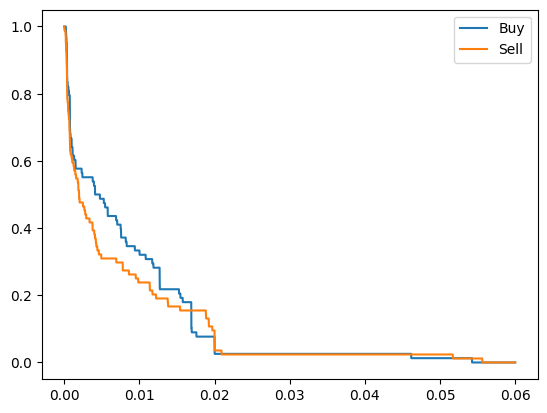

In [117]:
CDF.plot()

### Poisson process